# Model SignABC
Eksperimen model khresna v2 :
1. Split dataset dilakukan otomatis
2. Menggunakan augmentasi di data training
3. Menghilangkan kelas "NOTHING".
4. Model yang digunakan adalah model dari Bintang.
5. Dataset yang digunakan adalah dataset KhresnaV2 yang udah ditambahin +- 7000 dataset baru


# Import Dependencies

In [1]:
!pip install -q tflite_support
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

In [1]:
import os
import random
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import PIL
import PIL.Image
import tensorflow_hub as hub
import tensorflowjs as tfjs

from google.colab import drive, files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Setup

In [2]:
# Mount google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Unzip dataset file
!unzip "/content/drive/MyDrive/Zipped dataset/Dataset_Experimen_Khresna/Dataset_KhresnaV2(NoSplit).zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/124.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/125 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/125.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/126 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/126.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/127 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/127.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/128 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/128.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/129 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/129.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/13 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/13.jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/130 (2).jpg  
  inflating: /content/Dataset_KhresnaV2(NoSplit)/Q/130.jpg  
  inflat

In [ ]:
# Dataset path
data_dir = pathlib.Path('/content/Dataset_KhresnaV2(NoSplit)')
# Image count
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.PNG')))
print("Total data:", image_count)


Total data: 13535


#Dataset
With augmentation(training) and normalization(validation)


In [ ]:
# Dataset properties
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13535 files belonging to 26 classes.
Using 10828 files for training.


In [ ]:
# Testing dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13535 files belonging to 26 classes.
Using 2707 files for validation.


In [ ]:
# Labels list
class_names = np.array(train_ds.class_names)
print(class_names)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


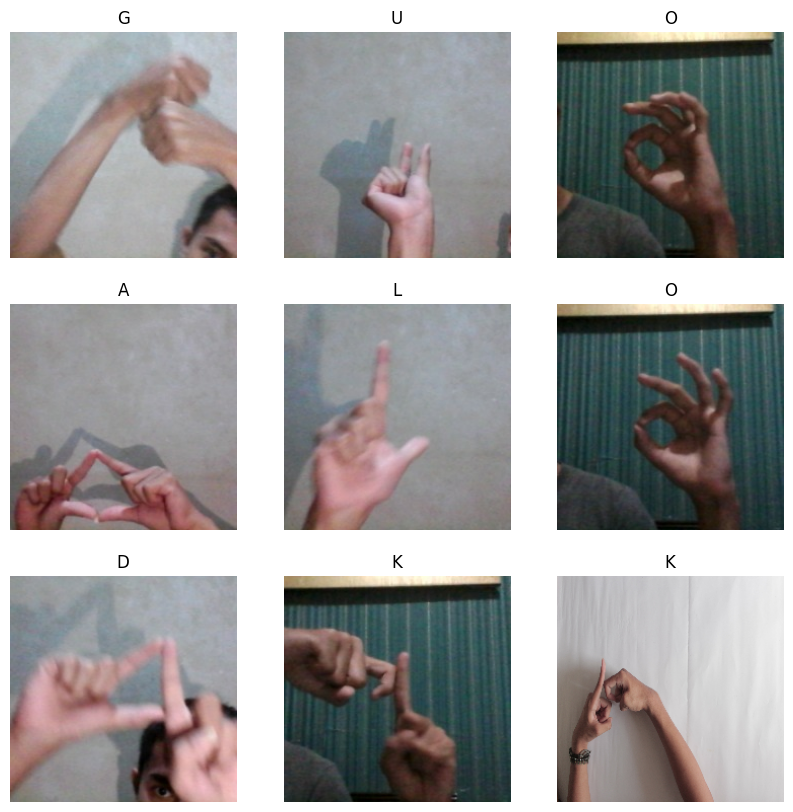

In [ ]:
# Dataset sample

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Augment training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.8),


])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


In [ ]:
# Normalize validation dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Autotune cache and paralellization to improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Without Transfer Learning



##Model Bintang

### Model Architecture

In [ ]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(26, activation = 'softmax')
    ])

    return model

### Tune Learning Rate

In [ ]:
# Method to find the 'best' learning rate
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Find the 'best' learning rate
lr_history = adjust_learning_rate(train_ds)

Epoch 1/100


ValueError: ignored

In [ ]:
# Plot the result
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

NameError: ignored

> The 'best' learning rate would be around 1e-3 as that area has quite stable loss compared to the other area.

### Train Model

In [ ]:
model = create_uncompiled_model()

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

NameError: ignored

### Model Evaluation

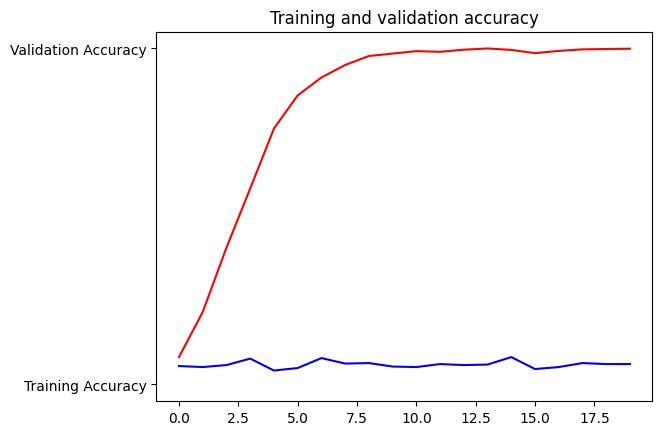

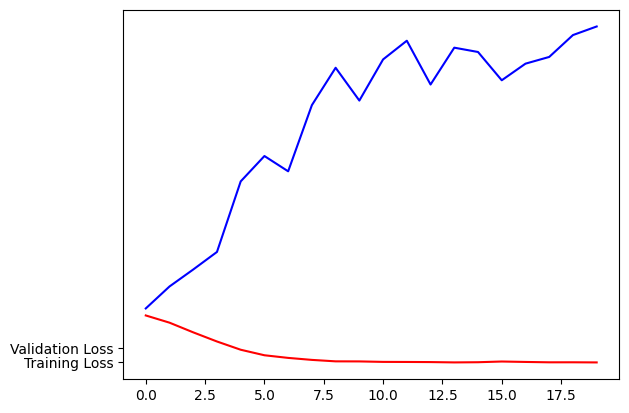

In [ ]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Save Model

In [ ]:
export_dir = 'saved_model/without_transfer'
tf.saved_model.save(model, export_dir)

##AlexNet Architecture

###Model arcihtecture

In [ ]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height,img_width,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

### Model preview

In [ ]:
model = create_uncompiled_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                      

###Train Model

In [ ]:
history = model.fit(train_ds,
          epochs=25,
          validation_data=val_ds)

Epoch 1/25
339/339 [==============================] - 229s 629ms/step - loss: 3.3700 - accuracy: 0.1612 - val_loss: 2.4465 - val_accuracy: 0.2579
Epoch 2/25
339/339 [==============================] - 214s 624ms/step - loss: 1.8462 - accuracy: 0.4593 - val_loss: 2.3423 - val_accuracy: 0.2671
Epoch 3/25
339/339 [==============================] - 196s 570ms/step - loss: 1.1228 - accuracy: 0.6578 - val_loss: 1.1944 - val_accuracy: 0.6358
Epoch 4/25
339/339 [==============================] - 207s 604ms/step - loss: 0.7276 - accuracy: 0.7794 - val_loss: 0.6086 - val_accuracy: 0.8090
Epoch 5/25
339/339 [==============================] - 203s 591ms/step - loss: 0.5855 - accuracy: 0.8204 - val_loss: 1.2505 - val_accuracy: 0.6339
Epoch 6/25
339/339 [==============================] - 208s 608ms/step - loss: 0.4626 - accuracy: 0.8547 - val_loss: 0.3571 - val_accuracy: 0.9036
Epoch 7/25
339/339 [==============================] - 194s 564ms/step - loss: 0.3324 - accuracy: 0.8943 - val_loss: 1.6066 -

# With Transfer Learning



## Load Pre-trained Model

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [ ]:
# Create layer from pre-trained model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)

## Model Architecture

In [ ]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

## Tune Learning Rate

In [ ]:
# Method to find the 'best' learning rate
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Find the 'best' learning rate
lr_history = adjust_learning_rate(train_ds)

Epoch 1/100
95/95 [==============================] - 5s 39ms/step - loss: 3.4171 - accuracy: 0.0574 - lr: 1.0000e-04
Epoch 2/100
95/95 [==============================] - 4s 39ms/step - loss: 2.8115 - accuracy: 0.2308 - lr: 1.1220e-04
Epoch 3/100
95/95 [==============================] - 4s 37ms/step - loss: 2.3436 - accuracy: 0.4592 - lr: 1.2589e-04
Epoch 4/100
95/95 [==============================] - 4s 38ms/step - loss: 1.9565 - accuracy: 0.5959 - lr: 1.4125e-04
Epoch 5/100
95/95 [==============================] - 4s 41ms/step - loss: 1.6476 - accuracy: 0.6771 - lr: 1.5849e-04
Epoch 6/100
95/95 [==============================] - 4s 38ms/step - loss: 1.4037 - accuracy: 0.7263 - lr: 1.7783e-04
Epoch 7/100
95/95 [==============================] - 4s 37ms/step - loss: 1.2093 - accuracy: 0.7672 - lr: 1.9953e-04
Epoch 8/100
95/95 [==============================] - 4s 38ms/step - loss: 1.0511 - accuracy: 0.8026 - lr: 2.2387e-04
Epoch 9/100
95/95 [==============================] - 4s 37ms/ste

(0.0001, 10.0, 0.0, 10.0)

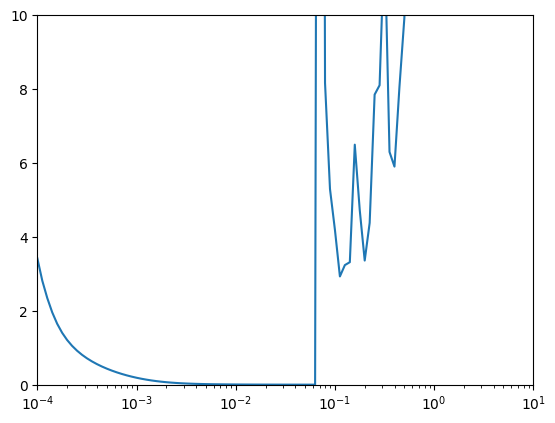

In [ ]:
# Plot the result
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

> The 'best' learning rate would be around 1e-3 as that area has quite stable loss compared to the other area.

## Train Model

In [ ]:
model = create_uncompiled_model()

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
339/339 [==============================] - 285s 799ms/step - loss: 2.1968 - accuracy: 0.3914 - val_loss: 1.6462 - val_accuracy: 0.5031
Epoch 2/25
339/339 [==============================] - 271s 787ms/step - loss: 1.3375 - accuracy: 0.6326 - val_loss: 1.3373 - val_accuracy: 0.5940
Epoch 3/25
339/339 [==============================] - 267s 782ms/step - loss: 1.0633 - accuracy: 0.7157 - val_loss: 1.1997 - val_accuracy: 0.6243
Epoch 4/25
339/339 [==============================] - 266s 779ms/step - loss: 0.9263 - accuracy: 0.7483 - val_loss: 1.0949 - val_accuracy: 0.6524
Epoch 5/25
339/339 [==============================] - 266s 777ms/step - loss: 0.8502 - accuracy: 0.7607 - val_loss: 1.0334 - val_accuracy: 0.6749
Epoch 6/25
339/339 [==============================] - 266s 779ms/step - loss: 0.7829 - accuracy: 0.7796 - val_loss: 0.9575 - val_accuracy: 0.6978
Epoch 7/25
339/339 [==============================] - 265s 774ms/step - loss: 0.7189 - accuracy: 0.7964 - val_loss: 0.9555 -

In [ ]:
tfjs.converters.save_keras_model(model, '/content')

In [ ]:
$ tensorflowjs_converter \
    --input_format=keras_saved_model \
    ./ \
    ./predict_houses_tfjs

## Model Evaluation

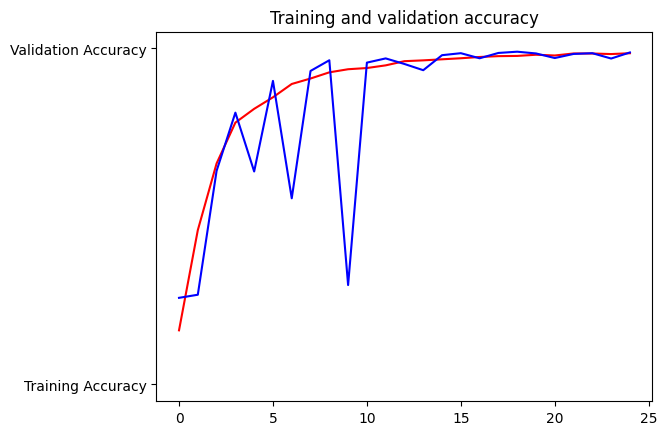

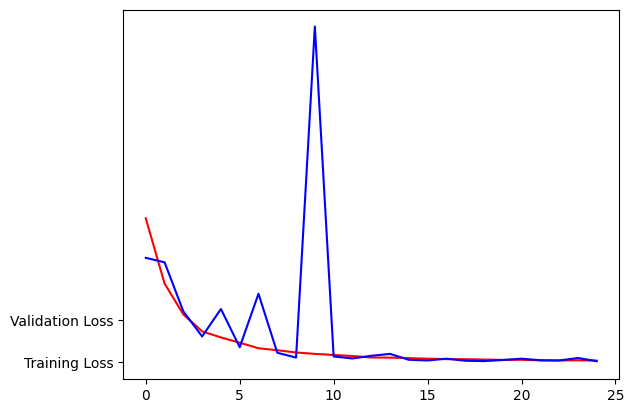

In [ ]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## Test with Uploaded Image

In [ ]:
# Upload image(s) and predict
uploaded=files.upload()

# Load images
for fn in uploaded.keys():

  path='/content/' + fn
  img=load_img(path, target_size=(img_height, img_width))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # Predict
  predicted_batch = model.predict(images)
  predicted_id = tf.math.argmax(predicted_batch, axis=-1)
  predicted_label_batch = class_names[predicted_id]
  print(predicted_label_batch)
  print(predicted_id)

Saving 7.jpg to 7.jpg
1/1 [==============================] - 0s 23ms/step
Z
tf.Tensor([25], shape=(1,), dtype=int64)


<ipython-input-33-04f912228fc9>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  predicted_label_batch = class_names[predicted_id]


In [ ]:
# Upload manually
path = '/content/Photo on 25-05-23 at 01.30 copy 2.jpg'
img=load_img(path, target_size=(img_height, img_width))
print(img)
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

predicted_batch = model.predict(images)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

FileNotFoundError: ignored

## Save Model

###Saved_model format


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
!zip -r "/content/saved_model.zip" "/content/saved_model"

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 94%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 69%)


###H5_Format

In [ ]:
!mkdir -p model_h5
model.save('model_h5/my_model.h5')

In [ ]:
!zip -r "/content/model_h5.zip" "/content/model_h5"

  adding: content/model_h5/ (stored 0%)
  adding: content/model_h5/my_model.h5 (deflated 26%)


###TFJS Converter (H5)

In [ ]:
!tensorflowjs_converter --input_format=keras /content/model_h5/my_model.h5 /tmp/tfjs_model

2023-06-08 18:32:53.617510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r "/content/tfjs_model.zip" "/tmp/tfjs_model"

  adding: tmp/tfjs_model/ (stored 0%)
  adding: tmp/tfjs_model/group1-shard4of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard5of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard37of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard36of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard31of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard29of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard16of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard28of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard34of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard32of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard43of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard6of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard26of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-shard39of45.bin (deflated 9%)
  adding: tmp/tfjs_model/group1-shard14of45.bin (deflated 8%)
  adding: tmp/tfjs_model/group1-sha

###Load model to Drive

In [ ]:
!cp /content/tfjs_model.zip '/content/drive/MyDrive/Model'
!ls -lt '/content/drive/MyDrive/Model/'

total 709272
-rw------- 1 root root 171502000 Jun  8 18:45 tfjs_model.zip
-rw------- 1 root root 277422289 Jun  8 18:43 saved_model.zip
-rw------- 1 root root 277369560 Jun  8 18:39 model_h5.zip


###To TFLITE

In [3]:
!unzip "/content/drive/MyDrive/Model/saved_model.zip" -d "/content"

Archive:  /content/drive/MyDrive/Model/saved_model.zip
   creating: /content/content/saved_model/
   creating: /content/content/saved_model/my_model/
 extracting: /content/content/saved_model/my_model/fingerprint.pb  
   creating: /content/content/saved_model/my_model/assets/
  inflating: /content/content/saved_model/my_model/saved_model.pb  
  inflating: /content/content/saved_model/my_model/keras_metadata.pb  
   creating: /content/content/saved_model/my_model/variables/
  inflating: /content/content/saved_model/my_model/variables/variables.data-00000-of-00001  
  inflating: /content/content/saved_model/my_model/variables/variables.index  


In [5]:



_TFLITE_MODEL_PATH = "/content/tflite"
converter = tf.lite.TFLiteConverter.from_saved_model('/content/content/saved_model/my_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()



In [8]:
with open('/content/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [9]:
!cp /content/tflite/model.tflite '/content/drive/MyDrive/Model/tflite'

#Hasil Eksperimen(belum di update)



##Pre Trained Model Inception Feature Extractor


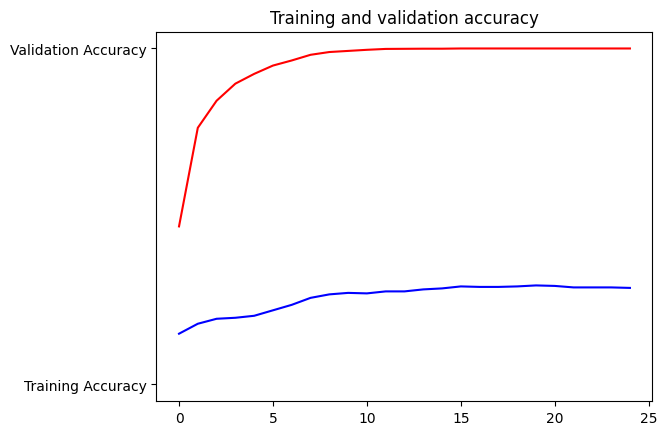

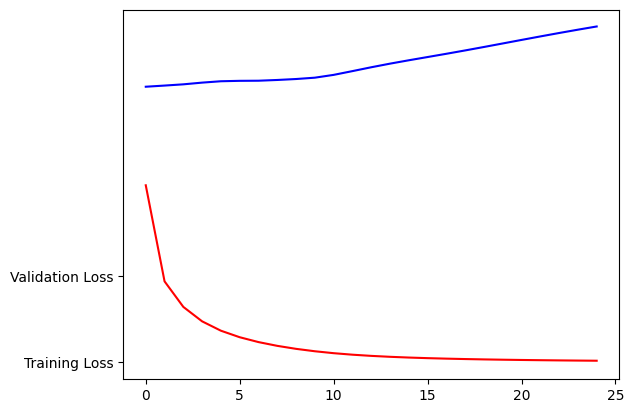

##Pre Trained Model MobileNet Feature Extractor

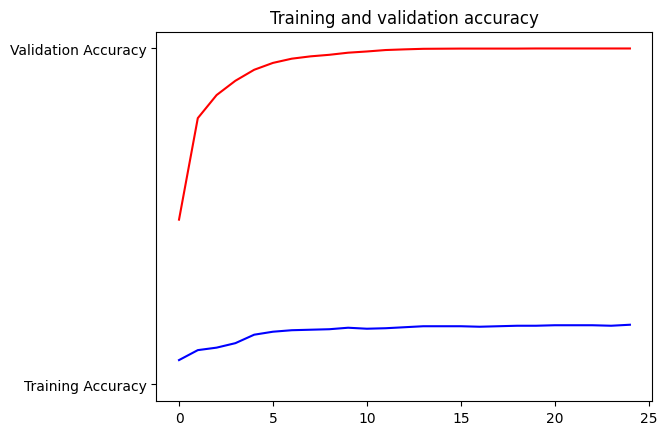

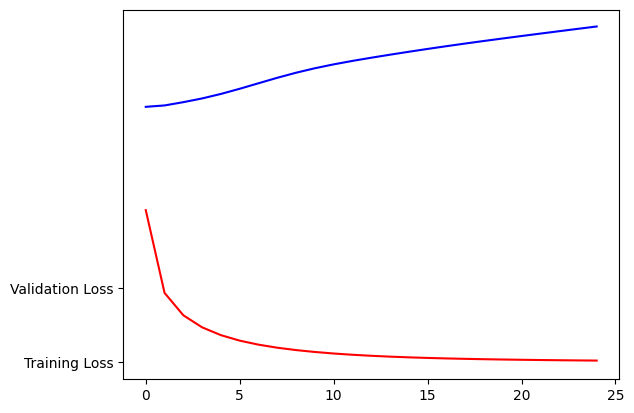

## No pre-trained model

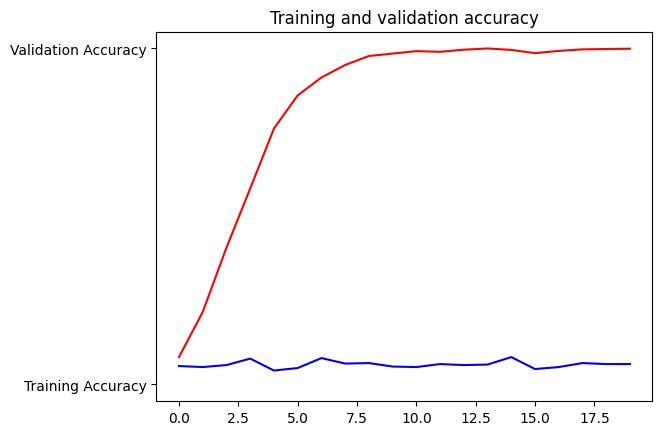

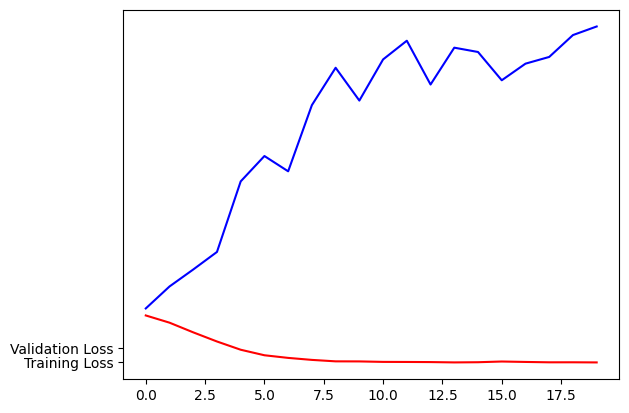